# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Data Exploration for grapes olives in Italy 2020-2021
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2020-2021. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [4]:
grapes_olives = pd.read_csv('grapes-olives_final_2006-2019.csv',skipinitialspace=True)
grapes_olives.head()

City             Type_crop  Year  total_ha  production_tonnes    PS  \
0  Palermo  Grapes for table use  2006     80.00            1120.00 99.07   
1  Palermo  Grapes for table use  2006     80.00            1120.00 99.07   
2  Palermo  Grapes for table use  2006     80.00            1120.00 99.07   
3  Palermo  Grapes for table use  2006     80.00            1120.00 99.07   
4  Palermo  Grapes for table use  2007     80.00            1008.00 99.00   

     TS  QV2M  RH2M  WS2M  ...  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  \
0 18.06  9.12 72.18  3.01  ...    10.30      0.61      0.62      47.05   
1 18.06  9.12 72.18  3.01  ...    10.30      0.61      0.62      47.05   
2 18.06  9.12 72.18  3.01  ...    10.30      0.61      0.62      47.05   
3 18.06  9.12 72.18  3.01  ...    10.30      0.61      0.62      47.05   
4 18.36  9.22 72.80  3.13  ...    10.39      0.62      0.62      48.50   

   T2M_RANGE  PRECTOTCORR       Type_fertilizer  Fertilizers_tonnes   lat  \
0      17.55         1.49               organic              163.60 38.12   
1      17.55         1.49    nitrogen-potassium                6.60 38.12   
2      17.55         1.49  phosphorus-potassium              565.70 38.12   
3      17.55         1.49               organic              461.90 38.12   
4      16.69         2.18               organic              189.30 38.12   

    lon  
0 13.36  
1 13.36  
2 13.36  
3 13.36  
4 13.36  

[5 rows x 22 columns]

In [5]:
grapes_olives. 	Type_crop.unique()

array(['Grapes for table use'], dtype=object)

In [4]:
grapes_olives = grapes_olives[grapes_olives["Year"] > 2019]

In [5]:
grapes_olives. 	Type_crop.unique()

array(['Grapes for table use', 'table olives', 'oil olives',
       'grapes for wines with protected designation of origin (pdo)',
       'grapes for wines with protected geographical indication (pgi)',
       'grapes for other wines n.e.c. (without pdo/pgi)', 'other olives',
       'grapes for other purposes n.e.c.', 'grapes for raisins'],
      dtype=object)

In [6]:
grapes_olives.describe()

Year  total_ha  production_tonnes      PS      TS    QV2M    RH2M  \
count 4896.00   4896.00            4896.00 4896.00 4896.00 4896.00 4896.00   
mean  2020.50   4995.00           21791.57   97.94   15.07    7.95   71.79   
std      0.50  11706.24           54490.23    2.90    2.99    0.91    2.28   
min   2020.00      1.00               0.10   85.07    4.49    5.42   66.55   
25%   2020.00     63.00             335.40   96.84   13.20    7.24   70.33   
50%   2021.00    674.50            3955.00   98.61   15.38    7.98   71.41   
75%   2021.00   4000.00           18618.30   99.85   17.43    8.45   72.80   
max   2021.00  98900.00          721450.00  101.60   20.32   10.55   79.64   

         WS2M  GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  \
count 4896.00  4896.00  4896.00  4896.00   4896.00   4896.00    4896.00   
mean     2.27     0.63    25.55     5.67      0.62      0.63      50.34   
std      0.82     0.08     2.51     3.81      0.07      0.07       6.96   
min      0.56     0.44    16.13    -5.86      0.46      0.45      34.46   
25%      1.63     0.57    23.90     3.11      0.57      0.58      45.29   
50%      2.11     0.62    25.71     5.61      0.62      0.63      51.05   
75%      2.65     0.69    27.19     8.06      0.68      0.69      55.81   
max      4.35     0.89    30.84    14.27      0.80      0.79      66.22   

       T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes     lat     lon  
count    4896.00      4896.00             4896.00 4896.00 4896.00  
mean       19.88         2.03             1340.62   42.08   12.42  
std         3.63         0.57             4345.78    5.23    2.94  
min        10.15         0.93                0.00    0.00    0.00  
25%        17.63         1.58               49.00   40.68   10.40  
50%        20.91         2.00              238.00   42.85   12.52  
75%        22.43         2.37              983.00   44.90   14.33  
max        26.54         3.80            76184.00   46.17   18.17

## Pre-processing dataset 

In [7]:
def show_info(grapes_olives):
    print('DATASET SHAPE: ', grapes_olives.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(grapes_olives.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(grapes_olives.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(grapes_olives.isnull().sum())
show_info(grapes_olives)

DATASET SHAPE:  (4896, 22) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4896 entries, 48 to 8367
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                4896 non-null   object 
 1   Type_crop           4896 non-null   object 
 2   Year                4896 non-null   int64  
 3   total_ha            4896 non-null   float64
 4   production_tonnes   4896 non-null   float64
 5   PS                  4896 non-null   float64
 6   TS                  4896 non-null   float64
 7   QV2M                4896 non-null   float64
 8   RH2M                4896 non-null   float64
 9   WS2M                4896 non-null   float64
 10  GWETTOP             4896 non-null   float64
 11  T2M_MAX             4896 non-null   float64
 12  T2M_MIN             4896 non-null   float64
 13  GWETPROF            4896 non-null   float64
 14  GWE

In [8]:
grapes_olives.describe()

Year  total_ha  production_tonnes      PS      TS    QV2M    RH2M  \
count 4896.00   4896.00            4896.00 4896.00 4896.00 4896.00 4896.00   
mean  2020.50   4995.00           21791.57   97.94   15.07    7.95   71.79   
std      0.50  11706.24           54490.23    2.90    2.99    0.91    2.28   
min   2020.00      1.00               0.10   85.07    4.49    5.42   66.55   
25%   2020.00     63.00             335.40   96.84   13.20    7.24   70.33   
50%   2021.00    674.50            3955.00   98.61   15.38    7.98   71.41   
75%   2021.00   4000.00           18618.30   99.85   17.43    8.45   72.80   
max   2021.00  98900.00          721450.00  101.60   20.32   10.55   79.64   

         WS2M  GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  \
count 4896.00  4896.00  4896.00  4896.00   4896.00   4896.00    4896.00   
mean     2.27     0.63    25.55     5.67      0.62      0.63      50.34   
std      0.82     0.08     2.51     3.81      0.07      0.07       6.96   
min      0.56     0.44    16.13    -5.86      0.46      0.45      34.46   
25%      1.63     0.57    23.90     3.11      0.57      0.58      45.29   
50%      2.11     0.62    25.71     5.61      0.62      0.63      51.05   
75%      2.65     0.69    27.19     8.06      0.68      0.69      55.81   
max      4.35     0.89    30.84    14.27      0.80      0.79      66.22   

       T2M_RANGE  PRECTOTCORR  Fertilizers_tonnes     lat     lon  
count    4896.00      4896.00             4896.00 4896.00 4896.00  
mean       19.88         2.03             1340.62   42.08   12.42  
std         3.63         0.57             4345.78    5.23    2.94  
min        10.15         0.93                0.00    0.00    0.00  
25%        17.63         1.58               49.00   40.68   10.40  
50%        20.91         2.00              238.00   42.85   12.52  
75%        22.43         2.37              983.00   44.90   14.33  
max        26.54         3.80            76184.00   46.17   18.17

## Total grapes_olives production in 2006-2021

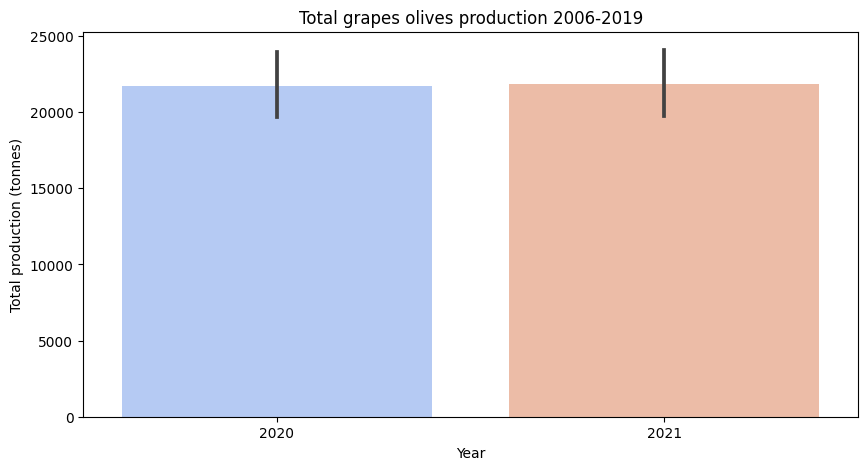

In [9]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'production_tonnes',data = grapes_olives,palette='coolwarm')
plt.title('Total grapes olives production 2006-2019')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Cereal production by Cities 

In [10]:
grapes_olives_region = grapes_olives.groupby(by = grapes_olives.City)['production_tonnes','City'].sum().reset_index().sort_values(by = 'production_tonnes', ascending = False).head(10)
grapes_olives_region

City  production_tonnes
89                Treviso        10109100.80
31                 Foggia         7844000.00
8   Barletta-Andria-Trani         4718800.00
84                Taranto         4098400.00
21                 Chieti         4090160.00
7                    Bari         3885680.00
88                Trapani         3546400.00
97                 Verona         3541224.80
71     Reggio di Calabria         3227390.40
0               Agrigento         3173668.80

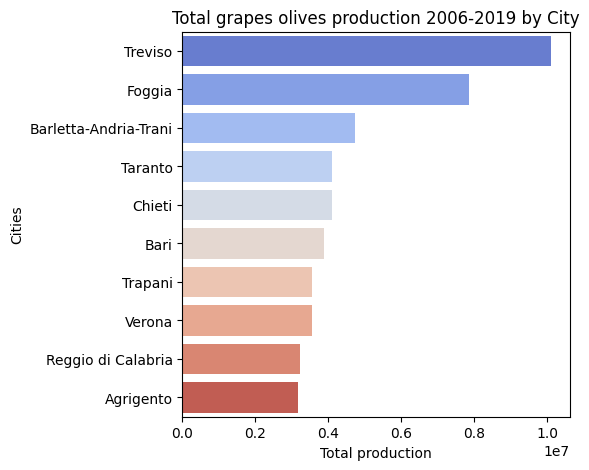

In [11]:
plt.figure(figsize= (5,5))
sns.barplot(x=grapes_olives_region['production_tonnes'],y= grapes_olives_region['City'], orient='h', palette='coolwarm');
plt.title('Total grapes olives production 2006-2019 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## grapes_olives highest production 2006-2021

In [12]:
print(grapes_olives.Type_crop.max())
print(grapes_olives.Type_crop.value_counts())
print(grapes_olives.Type_crop.nunique())



table olives
grapes for other wines n.e.c. (without pdo/pgi)                  824
oil olives                                                       772
other olives                                                     772
grapes for wines with protected designation of origin (pdo)      760
grapes for wines with protected geographical indication (pgi)    720
Grapes for table use                                             540
table olives                                                     452
grapes for other purposes n.e.c.                                  48
grapes for raisins                                                 8
Name: Type_crop, dtype: int64
9


In [13]:
grapes_olives.Type_crop.unique()


array(['Grapes for table use', 'table olives', 'oil olives',
       'grapes for wines with protected designation of origin (pdo)',
       'grapes for wines with protected geographical indication (pgi)',
       'grapes for other wines n.e.c. (without pdo/pgi)', 'other olives',
       'grapes for other purposes n.e.c.', 'grapes for raisins'],
      dtype=object)

In [14]:
grapes_olives = grapes_olives.replace('Grapes for table use','grapes-table')
grapes_olives = grapes_olives.replace('grapes for other purposes n.e.c.','grapes-n.e.c')
grapes_olives = grapes_olives.replace('grapes for raisins','grapes-raisins')
grapes_olives = grapes_olives.replace('grapes for other wines n.e.c. (without pdo/pgi)','grapes-wines(N-pdo/pgi)')
grapes_olives = grapes_olives.replace('grapes for wines with protected designation of origin (pdo)','grapes-wines(Y-pdo)')
grapes_olives = grapes_olives.replace('grapes for wines with protected geographical indication (pgi)','grapes-wines(Y-pgi)')

In [15]:
print(grapes_olives.total_ha.max())
print(grapes_olives.total_ha.min())
print(grapes_olives.total_ha.value_counts())
print(grapes_olives.total_ha.nunique())


98900.0
1.0
1.00       104
3.00        68
6.00        60
2.00        56
9.00        56
          ... 
3840.00      4
135.00       4
1240.00      4
780.00       4
2850.00      4
Name: total_ha, Length: 487, dtype: int64
487


In [ ]:
#grapes_olives.drop(grapes_olives[grapes_olives['total_area_ha'] == 0.00 ].index , inplace=True)

In [16]:
grapes_olives.describe().astype(int)

Year  total_ha  production_tonnes    PS    TS  QV2M  RH2M  WS2M  \
count  4896      4896               4896  4896  4896  4896  4896  4896   
mean   2020      4995              21791    97    15     7    71     2   
std       0     11706              54490     2     2     0     2     0   
min    2020         1                  0    85     4     5    66     0   
25%    2020        63                335    96    13     7    70     1   
50%    2021       674               3955    98    15     7    71     2   
75%    2021      4000              18618    99    17     8    72     2   
max    2021     98900             721450   101    20    10    79     4   

       GWETTOP  T2M_MAX  T2M_MIN  GWETPROF  GWETROOT  CLOUD_AMT  T2M_RANGE  \
count     4896     4896     4896      4896      4896       4896       4896   
mean         0       25        5         0         0         50         19   
std          0        2        3         0         0          6          3   
min          0       16       -5         0         0         34         10   
25%          0       23        3         0         0         45         17   
50%          0       25        5         0         0         51         20   
75%          0       27        8         0         0         55         22   
max          0       30       14         0         0         66         26   

       PRECTOTCORR  Fertilizers_tonnes   lat   lon  
count         4896                4896  4896  4896  
mean             2                1340    42    12  
std              0                4345     5     2  
min              0                   0     0     0  
25%              1                  49    40    10  
50%              2                 238    42    12  
75%              2                 983    44    14  
max              3               76184    46    18

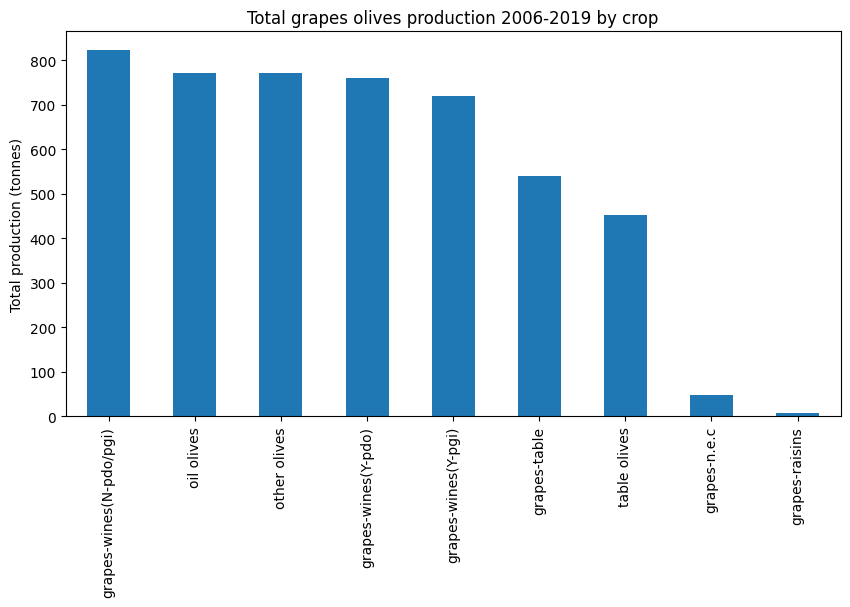

In [17]:
plt.figure(figsize=(10,5))
grapes_olives['Type_crop'].value_counts().plot.bar()
plt.title('Total grapes olives production 2006-2019 by crop')
plt.ylabel('Total production (tonnes)')
plt.show()


## Subseting data

In [ ]:
grapes_olives

In [ ]:
Q1 = grapes_olives.quantile(0.25)
Q3 = grapes_olives.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
# Remove outliers
grapes_olives = grapes_olives[~((grapes_olives < (Q1 - 1.5 * IQR)) | (grapes_olives > (Q3 + 1.5 * IQR))).any(axis=1)]
print(grapes_olives.shape)


In [ ]:
#Box plot and histplot (crop production distribuition)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.boxplot(data=grapes_olives, x='production_tonnes', y="Type_crop",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total grapes_olives production ')

plt.subplot(1,2,2)
sns.histplot(data=grapes_olives, x= 'production_tonnes',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total grapes_olives production')

plt.show()



In [ ]:
#Box plot and histplot of total area(ha)

plt.figure(figsize=(17,5))

plt.subplot(1,2,1)
sns.boxplot(data=grapes_olives, x='Year', y="total_ha",  color = 'darkblue', dodge=False)

plt.title(f'Box Plot total area (ha)')

plt.subplot(1,2,2)
sns.histplot(data=grapes_olives, x= 'total_ha',  color = 'darkblue', kde=True, bins = 80)
plt.title(f'Distribution total total area (ha)')

plt.show()

In [ ]:
print(grapes_olives.production_tonnes.max())
print(grapes_olives.production_tonnes.min())

In [ ]:
print(grapes_olives.total_ha.max())
print(grapes_olives.total_ha.min())


In [ ]:
print(grapes_olives.Fertilizers_tonnes.max())

In [ ]:
#Crop harvested by year

plotcrop10 = sns.relplot(kind='line', data=grapes_olives, x='Year', 
                         y='production_tonnes', hue='Type_crop', style='Type_crop', aspect=1.75)


In [ ]:
#Crop harvested by area/year

plotcrop10 = sns.relplot(kind='line', data=grapes_olives, x='Year', 
                         y='total_ha', hue='Type_crop', style='Type_crop', aspect=1.75)


In [ ]:
#Fertilizers distributed by year

plotfertilizers10 = sns.relplot(kind='line', data=grapes_olives, x='Year', 
                         y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)

# Climate data analysis

|Param_Code|Param_Name|Resolution|Depth [m]|Units|
|:--------:|:--------:|:--------:|:-------:|:---:|
|GWETPROF|Profile Soil Moisture|0.5° x 0.625°|1.34 - 8.53|water-free [0], saturated soil[1]| 
|GWETTOP|Surface Soil Wetness|0.5° x 0.625°|0.00 - 0.05| water-free [0], saturated soil[1]|
|GWETROOT|Root Zone Soil Wetness|0.5° x 0.625°|0.10 - 1.00|water-free [0], saturated soil[1]|
|CLOUD_AMT|Cloud Amount|---|---|%|
|TS|Earth Skin Temperature|---|---|°C|
|PS|Surface Pressure|---|---|kPa|
|RH2M|Relative Humidity at 2 Meters|---|---|%|
|QV2M|Specific Humidity at 2 Meters|---|---|g/kg|
|PRECTOTCORR|Precipitation Corrected|---|---|mm/day|
|T2M_MAX|Temperature at 2 Meters Maximum|---|---|°C|
|T2M_MIN|Temperature at 2 Meters Minimum|---|---|°C|
|T2M_RANGE|Temperature at 2 Meters Range|---|---|°C|
|WS2M|Wind Speed at 2 Meters|---|---|m/s|


  

*Precipitation Corrected (PRECTOTCORR)- [The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow)]

*Source? https://power.larc.nasa.gov/#resources

In [ ]:

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(20,10))

fig.suptitle('Climate in Italy 2006 - 2021')

grapes_olives['Year'] = (grapes_olives['Year']).astype(str)

# relative_humidity
sns.lineplot(data= grapes_olives, x="Year", y="RH2M", ax=ax[0,0])

# precipitation
sns.lineplot(data= grapes_olives, x="Year", y="PRECTOTCORR", ax=ax[0,1])

# temp_max
sns.lineplot(data= grapes_olives, x="Year", y="T2M_MIN", ax=ax[1,0])

# temp_min
sns.lineplot(data= grapes_olives, x="Year", y="T2M_MAX", ax=ax[1,1])

# surface_soil_wetness
sns.lineplot(data= grapes_olives, x="Year", y="GWETTOP", ax=ax[2,0])

# root_zone_wetness
sns.lineplot(data= grapes_olives, x="Year", y="GWETROOT", ax=ax[2,1])


In [ ]:
grapes_olives

In [ ]:
grapes_olives_model = grapes_olives.drop(columns =['Year','PS','TS','GWETTOP', 'QV2M','WS2M','T2M_RANGE','GWETPROF','CLOUD_AMT','PRECTOTCORR','lat', 'lon'  ])
grapes_olives_model

In [ ]:
grapes_olives_model = grapes_olives_model.to_csv('grapes_olives_model2019-2021.csv', index=False)

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html

https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

https://lost-stats.github.io/Presentation/Figures/heatmap_colored_correlation_matrix.html

https://plotly.com/python/box-plots/

https://pycaret.org/